In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from models.generative.gans.LSGAN import LSGAN
from models.generative.gans.utils import save_loss
from data_manipulation.data import Data
from models.generative.gans.utils import plot_images

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

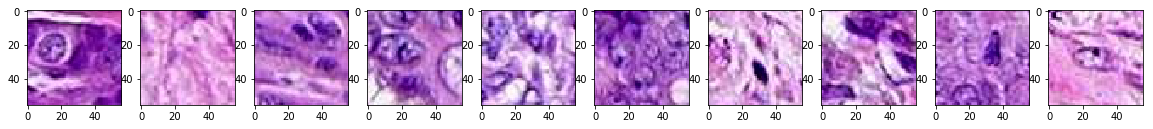

In [2]:
data = Data(dataset='nki', marker='he', patch_h=56, patch_w=56, n_channels=3, batch_size=10)
images, label = data.training.next_batch(10)

plot_images(plt_num=10, images=images, dim=20)

Epochs 1/3: Generator Loss: 0.2192. Discriminator Loss: 0.3651


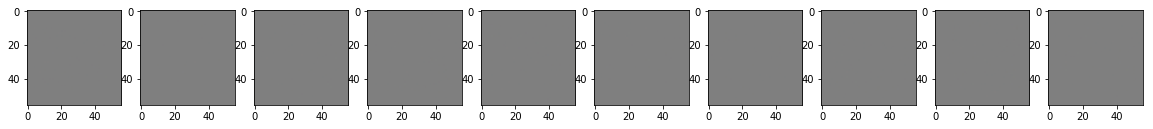

Epochs 1/3: Generator Loss: 0.1531. Discriminator Loss: 0.3627
Epochs 1/3: Generator Loss: 0.1698. Discriminator Loss: 0.368
Epochs 1/3: Generator Loss: 0.2057. Discriminator Loss: 0.3502
Epochs 1/3: Generator Loss: 0.2228. Discriminator Loss: 0.3393
Epochs 1/3: Generator Loss: 0.2284. Discriminator Loss: 0.2985
Epochs 1/3: Generator Loss: 0.2429. Discriminator Loss: 0.2457
Epochs 1/3: Generator Loss: 0.2467. Discriminator Loss: 0.3045
Epochs 1/3: Generator Loss: 0.2989. Discriminator Loss: 0.2407
Epochs 1/3: Generator Loss: 0.2888. Discriminator Loss: 0.216
Epochs 1/3: Generator Loss: 0.2665. Discriminator Loss: 0.2037


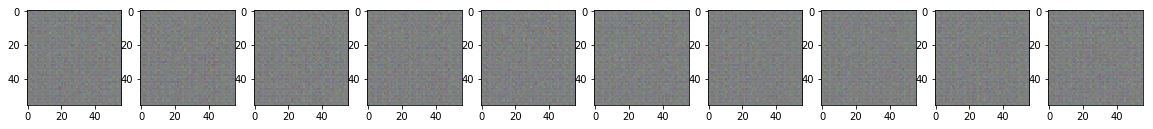

Epochs 1/3: Generator Loss: 0.3294. Discriminator Loss: 0.1724
Epochs 1/3: Generator Loss: 0.3193. Discriminator Loss: 0.2031
Epochs 1/3: Generator Loss: 0.3229. Discriminator Loss: 0.1939
Epochs 1/3: Generator Loss: 0.3182. Discriminator Loss: 0.1636
Epochs 1/3: Generator Loss: 0.3318. Discriminator Loss: 0.1168
Epochs 1/3: Generator Loss: 0.329. Discriminator Loss: 0.1708
Epochs 1/3: Generator Loss: 0.3251. Discriminator Loss: 0.1759
Epochs 1/3: Generator Loss: 0.3251. Discriminator Loss: 0.1447
Epochs 1/3: Generator Loss: 0.3328. Discriminator Loss: 0.1808
Epochs 1/3: Generator Loss: 0.321. Discriminator Loss: 0.2157


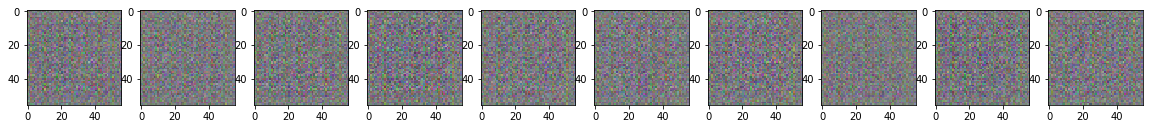

Epochs 1/3: Generator Loss: 0.3655. Discriminator Loss: 0.1185
Epochs 1/3: Generator Loss: 0.3486. Discriminator Loss: 0.1582
Epochs 1/3: Generator Loss: 0.3472. Discriminator Loss: 0.1441
Epochs 1/3: Generator Loss: 0.3559. Discriminator Loss: 0.1132
Epochs 1/3: Generator Loss: 0.2939. Discriminator Loss: 0.2373
Epochs 1/3: Generator Loss: 0.3269. Discriminator Loss: 0.2183
Epochs 1/3: Generator Loss: 0.3582. Discriminator Loss: 0.1504
Epochs 1/3: Generator Loss: 0.4155. Discriminator Loss: 0.1152
Epochs 1/3: Generator Loss: 0.0296. Discriminator Loss: 0.4476
Epochs 1/3: Generator Loss: 0.0632. Discriminator Loss: 0.4758


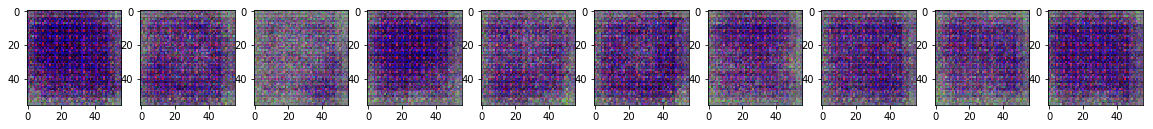

Epochs 1/3: Generator Loss: 0.1956. Discriminator Loss: 0.2257
Epochs 1/3: Generator Loss: 0.1998. Discriminator Loss: 0.2339
Epochs 1/3: Generator Loss: 0.2094. Discriminator Loss: 0.2833
Epochs 1/3: Generator Loss: 0.1383. Discriminator Loss: 0.2168
Epochs 1/3: Generator Loss: 0.2325. Discriminator Loss: 0.2439
Epochs 1/3: Generator Loss: 0.1281. Discriminator Loss: 0.2198
Epochs 1/3: Generator Loss: 0.2289. Discriminator Loss: 0.1727
Epochs 1/3: Generator Loss: 0.2109. Discriminator Loss: 0.1895
Epochs 1/3: Generator Loss: 0.2945. Discriminator Loss: 0.1069
Epochs 1/3: Generator Loss: 0.2536. Discriminator Loss: 0.1886


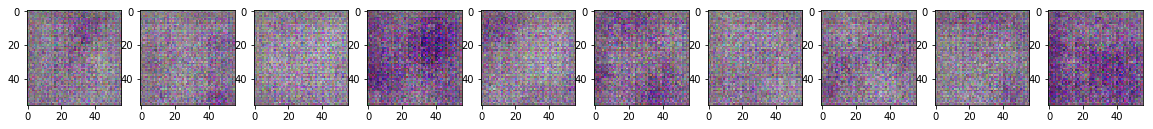

Epochs 1/3: Generator Loss: 0.2481. Discriminator Loss: 0.1836
Epochs 1/3: Generator Loss: 0.1652. Discriminator Loss: 0.2269
Epochs 1/3: Generator Loss: 0.2921. Discriminator Loss: 0.1103
Epochs 1/3: Generator Loss: 0.1051. Discriminator Loss: 0.3253
Epochs 1/3: Generator Loss: 0.1872. Discriminator Loss: 0.2748
Epochs 1/3: Generator Loss: 0.3021. Discriminator Loss: 0.3064
Epochs 1/3: Generator Loss: 0.2571. Discriminator Loss: 0.2393
Epochs 1/3: Generator Loss: 0.2339. Discriminator Loss: 0.1818
Epochs 1/3: Generator Loss: 0.2174. Discriminator Loss: 0.2554
Epochs 1/3: Generator Loss: 0.1678. Discriminator Loss: 0.2646


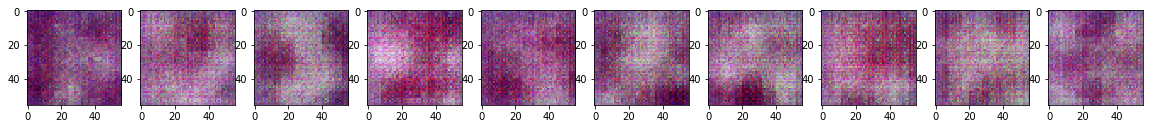

Epochs 1/3: Generator Loss: 0.275. Discriminator Loss: 0.1649
Epochs 1/3: Generator Loss: 0.2023. Discriminator Loss: 0.2133
Epochs 1/3: Generator Loss: 0.2352. Discriminator Loss: 0.2273
Epochs 1/3: Generator Loss: 0.1732. Discriminator Loss: 0.2914
Epochs 1/3: Generator Loss: 0.3093. Discriminator Loss: 0.2122
Epochs 1/3: Generator Loss: 0.1972. Discriminator Loss: 0.2051
Epochs 1/3: Generator Loss: 0.342. Discriminator Loss: 0.1262
Epochs 1/3: Generator Loss: 0.2555. Discriminator Loss: 0.2238
Epochs 1/3: Generator Loss: 0.2903. Discriminator Loss: 0.1416
Epochs 1/3: Generator Loss: 0.3241. Discriminator Loss: 0.2374


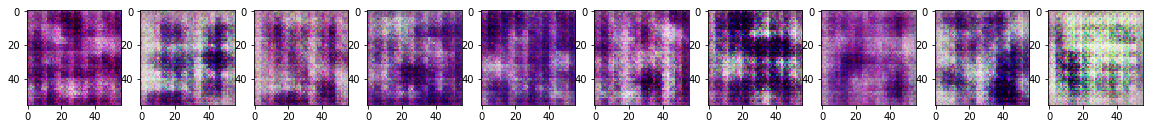

Epochs 1/3: Generator Loss: 0.2458. Discriminator Loss: 0.1696
Epochs 1/3: Generator Loss: 0.2797. Discriminator Loss: 0.1557
Epochs 1/3: Generator Loss: 0.1728. Discriminator Loss: 0.2483
Epochs 1/3: Generator Loss: 0.2559. Discriminator Loss: 0.1568
Epochs 1/3: Generator Loss: 0.3574. Discriminator Loss: 0.136
Epochs 1/3: Generator Loss: 0.1982. Discriminator Loss: 0.2125
Epochs 1/3: Generator Loss: 0.3224. Discriminator Loss: 0.1545
Epochs 1/3: Generator Loss: 0.2202. Discriminator Loss: 0.242
Epochs 1/3: Generator Loss: 0.3799. Discriminator Loss: 0.2595
Epochs 1/3: Generator Loss: 0.1672. Discriminator Loss: 0.2488


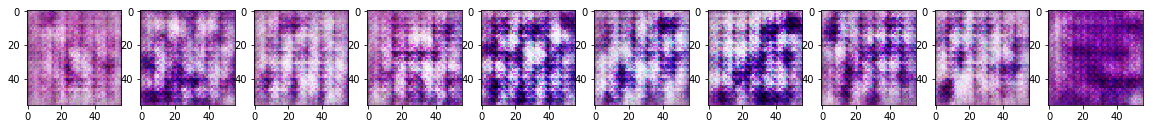

Epochs 1/3: Generator Loss: 0.3901. Discriminator Loss: 0.2387
Epochs 1/3: Generator Loss: 0.2222. Discriminator Loss: 0.2566
Epochs 1/3: Generator Loss: 0.2971. Discriminator Loss: 0.1694
Epochs 1/3: Generator Loss: 0.3251. Discriminator Loss: 0.1453
Epochs 1/3: Generator Loss: 0.1883. Discriminator Loss: 0.1845
Epochs 1/3: Generator Loss: 0.1477. Discriminator Loss: 0.2873
Epochs 1/3: Generator Loss: 0.2006. Discriminator Loss: 0.1934
Epochs 1/3: Generator Loss: 0.2441. Discriminator Loss: 0.2364
Epochs 1/3: Generator Loss: 0.2946. Discriminator Loss: 0.2254
Epochs 1/3: Generator Loss: 0.2442. Discriminator Loss: 0.2083


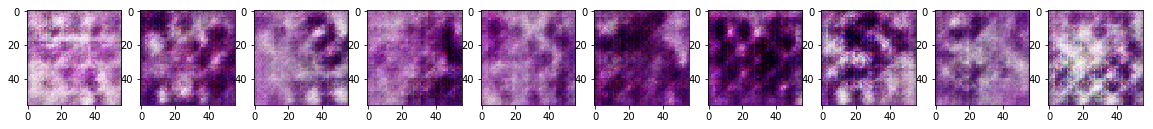

Epochs 1/3: Generator Loss: 0.1695. Discriminator Loss: 0.2779
Epochs 1/3: Generator Loss: 0.2021. Discriminator Loss: 0.2803
Epochs 1/3: Generator Loss: 0.1968. Discriminator Loss: 0.2415
Epochs 1/3: Generator Loss: 0.3649. Discriminator Loss: 0.2663
Epochs 1/3: Generator Loss: 0.3238. Discriminator Loss: 0.1344
Epochs 1/3: Generator Loss: 0.37. Discriminator Loss: 0.3432
Epochs 1/3: Generator Loss: 0.1289. Discriminator Loss: 0.2918
Epochs 1/3: Generator Loss: 0.1628. Discriminator Loss: 0.2283
Epochs 1/3: Generator Loss: 0.2752. Discriminator Loss: 0.2056
Epochs 1/3: Generator Loss: 0.2393. Discriminator Loss: 0.2307


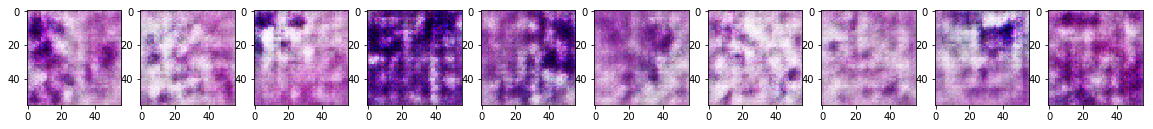

Epochs 1/3: Generator Loss: 0.0959. Discriminator Loss: 0.3711
Epochs 1/3: Generator Loss: 0.1677. Discriminator Loss: 0.2399
Epochs 1/3: Generator Loss: 0.3522. Discriminator Loss: 0.265


In [ ]:
main_path = '/Users/adalbertoclaudioquiros/Documents/Code/UofG/PhD/Cancer_TMA_Generative/data model output/LSGAN/'

# Dataset information.
image_width = 56
image_height = 56
image_channels = 3
dataset='nki'
marker='he'
name_run = 'h%s_w%s_n%s' % (image_height, image_width, image_channels)
data_out_path = '%s/%s' % (main_path, name_run)


# Hyperparameters.
epochs = 3
batch_size = 32
z_dim = 100
learning_rate = 1e-4
beta1 = 0.5
alpha = 0.2
use_bn = True

data = Data(dataset, marker, image_height, image_width, image_channels, batch_size)

with tf.Graph().as_default():
    lsgan = LSGAN(data, z_dim, use_bn, alpha, beta1, learning_rate, model_name='DCGAN')
    losses = lsgan.train(epochs, data_out_path, data)

In [ ]:
save_loss(losses, data_out_path, dim=20)